In [42]:
import hashlib
import time
import matplotlib.pyplot as plt
import concurrent.futures
import random
import string
import numpy as np

max_nonce = 2 ** 32  # 4 billion

def proof_of_work(header, difficulty_bits):
    # calculate the difficulty target
    target = 2 ** (256 - difficulty_bits)

    for nonce in range(max_nonce):
        hash_result = hashlib.sha256(str(header).encode() + str(nonce).encode()).hexdigest()

        # check if this is a valid result, below the target
        if int(hash_result, 16) < target:
            print("Success with nonce %d" % nonce)
            print("Hash is %s" % hash_result)
            return (hash_result, nonce)

    return nonce

def get_hash_time(_t):
    nonce = 0
    hash_result = ''.join(random.sample(string.ascii_uppercase + string.digits, k=24))

    res = []
    
    # difficulty from 0 to 31 bits
    for difficulty_bits in range(12, 26):
        difficulty = 2 ** difficulty_bits
        print("Difficulty: %ld (%d bits)" % (difficulty, difficulty_bits))

        # checkpoint the current time
        start_time = time.time()

        # new message that includes hash from previous proof
        new_message = hash_result

        # find a valid nonce for the new block
        (hash_result, nonce) = proof_of_work(new_message, difficulty_bits)

        # checkpoint how long it took to find a result
        end_time = time.time()

        elapsed_time = end_time - start_time
        
        res.append(elapsed_time)
        
    return res

all_res = []

In [43]:
pool = concurrent.futures.ProcessPoolExecutor(max_workers=4)

new_res = pool.map(get_hash_time, [1,1,1,1])

for i in new_res:
    all_res.append(i)

Difficulty: 4096 (12 bits)
Difficulty: 4096 (12 bits)
Success with nonce 1169
Difficulty: 4096 (12 bits)
Success with nonce 1164
Difficulty: 4096 (12 bits)
Hash is 000377b82ed3695a3c1ab3a71e96e7b5c01a93270a27f386efe5d9d0f557c9cf
Difficulty: 8192 (13 bits)
Success with nonce 8919
Hash is 000df0ae2ee9dee17305a2a9f2d58ed76c85bd41304ce62e2e90d233a1e32d9c
Difficulty: 8192 (13 bits)
Success with nonce 619
Hash is 0004d355d726c1ade9452b4d2d41235f89e90a0e68ea13c502b541f196657127
Difficulty: 16384 (14 bits)
Success with nonce 6097
Hash is 000b48f4c1e01fada66ff012c1ab20e6e9168accfff2dde2f6ec8b03c15ade1e
Difficulty: 8192 (13 bits)
Success with nonce 3302
Hash is 0005b26bb06b1035e8c5af9321dcf60d59226c61662d7ce31d50adc47a47e928
Hash is 00069e4bf93018b9691f2fc71a31ab2e96ebfc873742c3be1e5b07a94d321f39
Difficulty: 8192 (13 bits)
Success with nonce 5432
Difficulty: 16384 (14 bits)
Success with nonce 113
Hash is 0001e9c5a4521fd73d087e536a2a4fe2ea6c1c0084e271a7f01e769df489049c
Difficulty: 32768 (15 bits)

KeyboardInterrupt: 

In [ ]:
import seaborn as sns; sns.set()
from matplotlib.colors import ListedColormap
import numpy as np

my_cmap = ListedColormap(sns.color_palette("bright").as_hex())


plt.figure(figsize=(15,15))

for res in all_res:
    plt.plot([2**i for i in range(12, 26)], res[12:], alpha=0.7)
    
mean_res = np.mean(all_res, axis=0)

plt.plot([2**i for i in range(12, 26)], mean_res[12:], color='black', label='Mean')

plt.legend()
    
plt.title('PoW time/difficulty correlation')
plt.xscale("log")
plt.xlabel('Difficulty')
plt.ylabel('Time consumed, sec')

plt.show()

# POS

In [3]:
account_list = [i for i in range(6)]
pies = []
start = 50
for i in range(6):
    pies.append(start / 2**i)
    
thresholds, cur_threshold = [], pies[-1]
for i in pies[::-1][1:]:
    thresholds.append(cur_threshold)
    cur_threshold += i
thresholds.append(100)
    
count = [0 for i in range(6)]
# generating 100 blocks each time choosing miner with chance appropriate to his stake
for i in range(100):
    miner = random.randint(0, 101)
    found = False
    for num, i in enumerate(thresholds):
        if miner < i:
            count[num] += 1
            found = True
            break
    if not found:
        count[account_list[-1]] +=1

count = count[::-1]

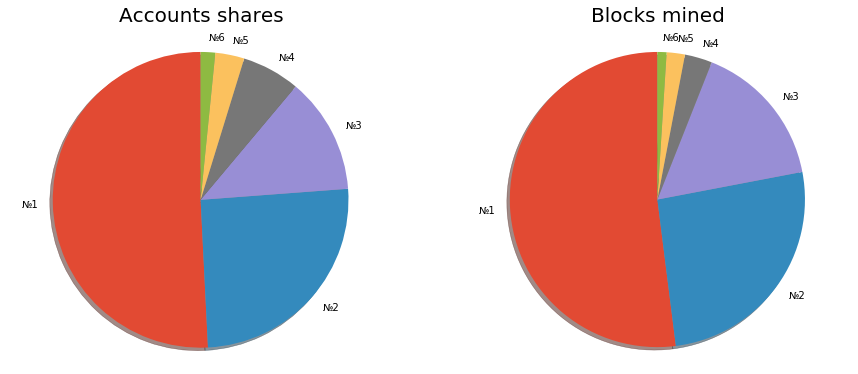

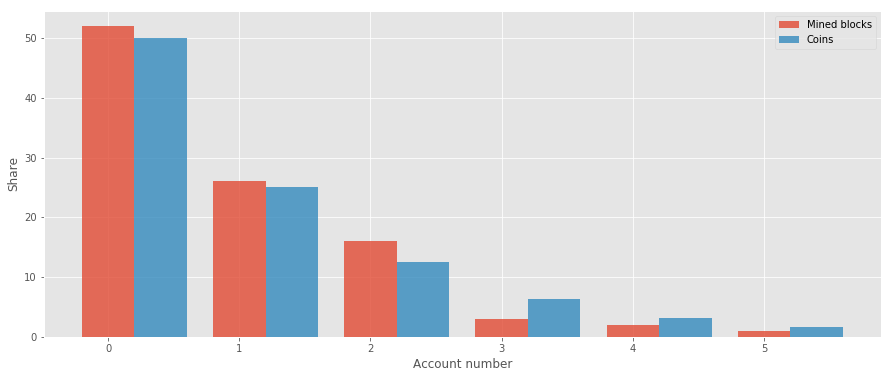

In [35]:
plt.figure(figsize=(15, 6))
plt.style.use('ggplot')

plt.subplot(1,2,1)

plt.pie(pies, labels=['№{}'.format(i+1) for i in account_list], shadow=True, startangle=90)
plt.axis('equal') 

plt.title('Accounts shares', size=20, y=1.03)

plt.subplot(1,2,2)

plt.pie(count, labels=['№{}'.format(i+1) for i in account_list], shadow=True, startangle=90)
plt.axis('equal') 

plt.title('Blocks mined', size=20, y=1.03)

plt.show()

plt.figure(figsize=(15, 6))

index = np.arange(len(account_list))
bar_width = 0.4

plt.bar(index, count, bar_width, alpha=0.8, label='Mined blocks')
plt.bar(index + bar_width, pies, bar_width, alpha=0.8, label='Coins')

plt.legend()
plt.xlabel('Account number')
plt.ylabel('Share')
plt.show()

# DPOS

In [120]:
account_list = [i for i in range(6)]
pies = []
start = 50
for i in range(6):
    pies.append(start / 2**i)
thresholds = []

def choose_miner():
    miner = random.randint(0, 101)
    for num, i in enumerate(thresholds):
        if miner < i:
            return num
        
    return account_list[-1]
            
    
miners_history = [0 for i in range(len(account_list))]
# 100 blocks, 4 blocks in epoch
for i in range(0, 500, 4):
    current_voting = [0 for i in range(len(account_list))]
    
    # every miner vote for someone
    for i in range(len(account_list)):
        current_voting[random.randint(0, 5)] += pies[i]
        
    # set thresholds accordingly to vote
    thresholds, cur_threshold = [], current_voting[0]
    for i in current_voting[1:]:
        thresholds.append(cur_threshold)
        cur_threshold += i
    thresholds.append(100)
            
    current_epoch_miners = []
    # choosing 4 candidates for mining
    # chance of picking denends on quantity of votes
    counter = 0
    while (len(current_epoch_miners) < 4):
        if counter > 100:
            current_epoch_miners.append((set([0,1,2,3,4,5]) - set(current_epoch_miners)).pop())
        miner = choose_miner()
        if miner in current_epoch_miners:
            counter +=1
            continue
        current_epoch_miners.append(miner)
        
    for i in current_epoch_miners:
        miners_history[i] += 1
        

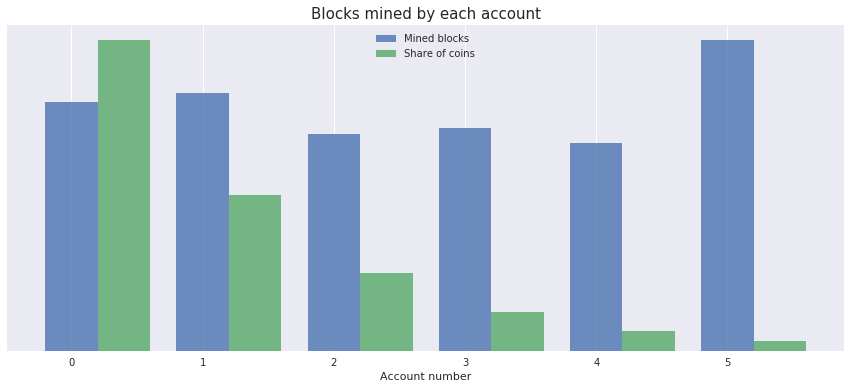

In [126]:
plt.figure(figsize=(15, 6))

miners_history = [i / max(miners_history) for i in miners_history]
pies = [i / max(pies) for i in pies]


index = np.arange(len(account_list))
bar_width = 0.4

# plt.hist(miners_history, bins=20, alpha=0.8)

plt.bar(index, miners_history, bar_width, alpha=0.8, label='Mined blocks')
plt.bar(index + bar_width, pies, bar_width, alpha=0.8, label='Share of coins')

plt.legend()

plt.title('Blocks mined by each account', size=15)
plt.xlabel('Account number')
plt.yticks([])
plt.show()